# Human Activity Recognition with Smartphones

This notebook descirbes experiments on [UCI-HAR](https://www.kaggle.com/datasets/uciml/human-activity-recognition-with-smartphones) dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing

In [2]:
TEST_DATA = 'test.csv'
TRAIN_DATA = 'train.csv'

In [3]:
train_df = pd.read_csv(TRAIN_DATA)
test_df = pd.read_csv(TEST_DATA)
train_df.shape

(7352, 563)

In [4]:
# print(*(f'{c}\n' for c in train_df.columns))

In [5]:
train_df['subject'].unique()

array([ 1,  3,  5,  6,  7,  8, 11, 14, 15, 16, 17, 19, 21, 22, 23, 25, 26,
       27, 28, 29, 30])

In [6]:
train_df['Activity'].unique()

array(['STANDING', 'SITTING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

<AxesSubplot:>

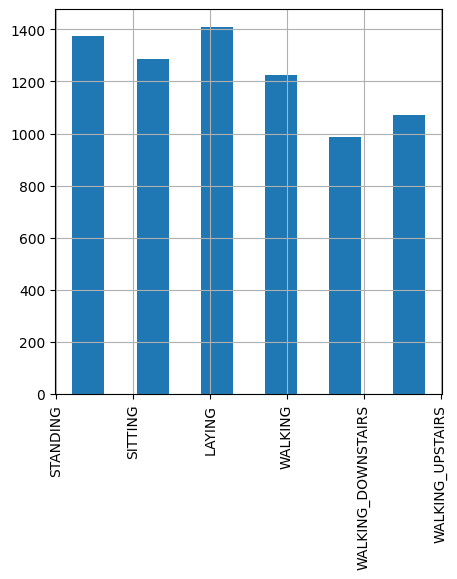

In [7]:
train_df['Activity'].hist(xrot=90, bins=6, figsize=(5,5), rwidth=0.5)

In [8]:
# remove laying and walking data
train_df = train_df[~train_df['Activity'].isin(['STANDING', 'WALKING'])]
test_df = test_df[~test_df['Activity'].isin(['STANDING', 'WALKING'])]

train_df.shape

(4752, 563)

<AxesSubplot:>

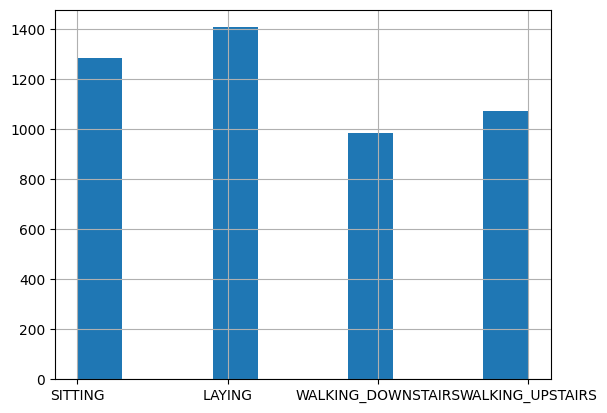

In [9]:
train_df['Activity'].hist()

In [10]:
features = [
    'tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X',
    'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-max()-X', 'tBodyAcc-max()-Y',
    'tBodyAcc-max()-Z', 'tBodyAcc-min()-X', 'tBodyAcc-min()-Y', 'tBodyAcc-min()-Z',
    'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
    'fBodyAcc-iqr()-X', 'fBodyAcc-iqr()-Y', 'fBodyAcc-iqr()-Z',
    
    'tBodyGyro-mean()-X', 'tBodyGyro-mean()-Y', 'tBodyGyro-mean()-Z', 'tBodyGyro-std()-X',
    'tBodyGyro-std()-Y', 'tBodyGyro-std()-Z', 'tBodyGyro-max()-X', 'tBodyGyro-max()-Y',
    'tBodyGyro-max()-Z', 'tBodyGyro-min()-X', 'tBodyGyro-min()-Y', 'tBodyGyro-min()-Z',
    'tBodyGyro-mad()-X', 'tBodyGyro-mad()-Y', 'tBodyGyro-mad()-Z',
    'tBodyGyro-iqr()-X', 'tBodyGyro-iqr()-Y', 'tBodyGyro-iqr()-Z',
    
    'tGravityAcc-std()-X', 'tGravityAcc-std()-Y', 'tGravityAcc-std()-Z', 'tGravityAcc-mad()-X',
    'tGravityAcc-mad()-Y', 'tGravityAcc-mad()-Z', 'tGravityAcc-max()-X', 'tGravityAcc-max()-Y',
    'tGravityAcc-max()-Z', 'tGravityAcc-min()-X', 'tGravityAcc-min()-Y', 'tGravityAcc-min()-Z',
    'tGravityAcc-iqr()-X', 'tGravityAcc-iqr()-Y', 'tGravityAcc-iqr()-Z',
    
    'Activity'
]

train_df = train_df[[f for f in features]]
test_df = test_df[[f for f in features]]
train_df.shape

(4752, 52)

In [11]:
X_train = train_df.iloc[:, :-1]
y_train = train_df[['Activity']]

X_test = test_df.iloc[:, :-1]
y_test = test_df[['Activity']]

In [12]:
le = preprocessing.LabelEncoder()
le.fit(y_train['Activity'].unique().tolist())

LabelEncoder()

In [13]:
y_train = le.transform(y_train)
y_test = le.transform(y_test)

/Users/nguyenvanbinh/Desktop/hardware-ai/venv/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [14]:
y_train

array([1, 1, 1, ..., 3, 3, 3])

## Pytorch model

In [15]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [16]:
input_size = 51
hidden_size = 75
num_classes = 4
num_epochs = 10
batch_size = 64
learning_rate = 0.01
device = torch.device('cpu')

In [17]:
class HarDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __getitem__(self, index):
        return torch.Tensor(self.X.iloc[index].astype(float)), self.y[index]
    
    def __len__(self):
        return len(self.X)

In [18]:
train_dataset = HarDataset(X_train, y_train)
test_dataset = HarDataset(X_test, y_test)

train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size, 
    shuffle=True
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [19]:
class FCN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FCN, self).__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out) 
        return out

In [20]:
model = FCN(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sb

def test_accuracy():
    y_pred = []
    y_true = []
    
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        for data, labels in test_loader:
            labels = labels.to(device)
            y_true.extend(labels)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            y_pred.extend(predicted)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

        acc = 100.0 * n_correct / n_samples
        print(f'Accuracy on test set: {acc:.4f}%')
        
        cf_mat = confusion_matrix(y_true, y_pred)
        cm_df = pd.DataFrame(cf_mat, index=[i for i in range(num_classes)], columns=[i for i in range(num_classes)])
        plt.figure(figsize=(4,3))
        sb.heatmap(cm_df, annot=True)

Before training
Accuracy on test set: 21.8864%


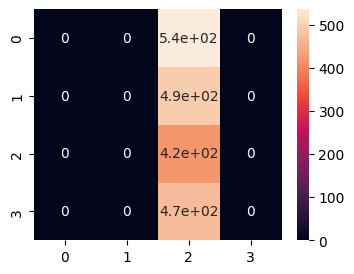

In [22]:
print('Before training')
test_accuracy()

In [23]:
n_total_steps = len(train_loader)
n_total_steps

75

In [24]:
time, losses = [], []
for epoch in range(num_epochs):
    for i, (data, label) in enumerate(train_loader):
        label = label.to(device)
        output = model(data)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        time.append(epoch)
        losses.append(loss.item())
    
    scheduler.step()

    if epoch % 2 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}: loss = {loss.item():.4f}', end='; ')
        print(f"learning rate = {optimizer.param_groups[0]['lr']}")

Epoch 1/10: loss = 0.0449; learning rate = 0.01


After training
Accuracy on test set: 96.1959%


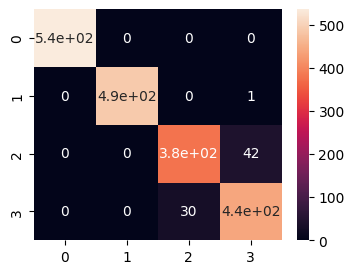

In [25]:
print('After training')
test_accuracy()

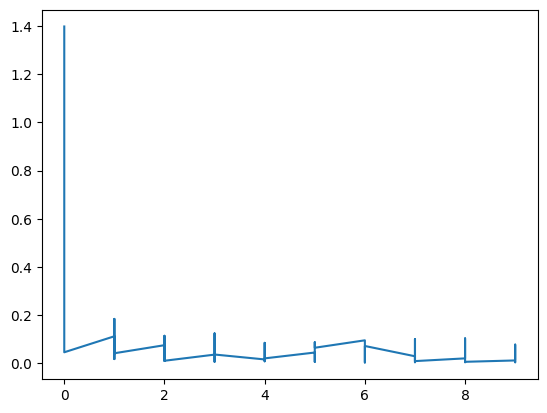

In [26]:
plt.plot(time, losses)

## Keras model

In [27]:
import tensorflow as tf 
from sklearn.preprocessing import OneHotEncoder

In [28]:
ohe = OneHotEncoder()

y_train_ohe = ohe.fit_transform(np.asarray(y_train).reshape(-1,1)).toarray()
y_test_ohe = ohe.fit_transform(np.asarray(y_test).reshape(-1,1)).toarray()

In [29]:
y_train_ohe

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [30]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(hidden_size, input_dim=input_size, activation='relu'))
model.add(tf.keras.layers.Dense(num_classes, activation='sigmoid'))

2022-09-02 16:20:16.535651: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [31]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Before training
60/60 - 0s - loss: 1.5497 - accuracy: 0.1803 - 272ms/epoch - 5ms/step
60/60 [==============================] - 0s 815us/step


<AxesSubplot:>

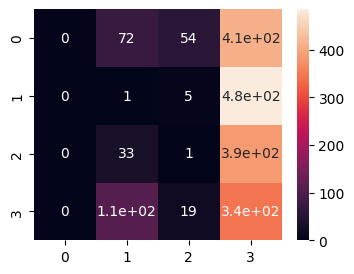

In [32]:
print("Before training")
model.evaluate(X_test, y_test_ohe, verbose=2)

labels = list(y_test)
predictions = model.predict(X_test)
predictions = [np.argmax(p) for p in model.predict(X_test)]
cf_mat = tf.math.confusion_matrix(labels, predictions)

cm_df = pd.DataFrame(cf_mat.numpy(), index=[i for i in range(num_classes)], columns=[i for i in range(num_classes)])
plt.figure(figsize=(4,3))
sb.heatmap(cm_df, annot=True)

In [33]:
model.fit(X_train, y_train_ohe, epochs=5)

Epoch 1/5
149/149 [==============================] - 0s 1ms/step - loss: 0.5863 - accuracy: 0.7868
Epoch 2/5
149/149 [==============================] - 0s 1ms/step - loss: 0.1962 - accuracy: 0.9407
Epoch 3/5
149/149 [==============================] - 0s 1ms/step - loss: 0.1197 - accuracy: 0.9657
Epoch 4/5
149/149 [==============================] - 0s 1ms/step - loss: 0.0897 - accuracy: 0.9747
Epoch 5/5
149/149 [==============================] - 0s 1ms/step - loss: 0.0710 - accuracy: 0.9781


After training
60/60 - 0s - loss: 0.1037 - accuracy: 0.9541 - 55ms/epoch - 910us/step
60/60 [==============================] - 0s 745us/step


<AxesSubplot:>

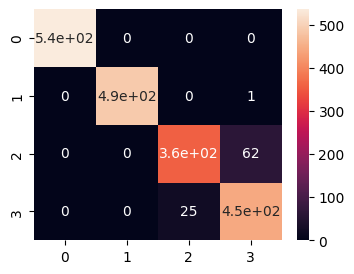

In [34]:
print("After training")
model.evaluate(X_test, y_test_ohe, verbose=2)
labels = list(y_test)
predictions = model.predict(X_test)
predictions = [np.argmax(p) for p in model.predict(X_test)]
cf_mat = tf.math.confusion_matrix(labels, predictions)

cm_df = pd.DataFrame(cf_mat.numpy(), index=[i for i in range(num_classes)], columns=[i for i in range(num_classes)])
plt.figure(figsize=(4,3))
sb.heatmap(cm_df, annot=True)